In [50]:
from datetime import datetime
import os

from google.cloud import bigquery, storage
import pandas as pd

In [51]:
bigquery_client = bigquery.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")
storage_client = storage.Client.from_service_account_json("../../config/neuraltwin-545b2b43070a.json")

In [52]:
TODAY = datetime(year=2025, month=8, day=2)

# Generate bigquery tables for measurements, failures, and metadata from raw data in GCS

In [53]:
def load_folder_into_bigquery(folder_url: str, table_id: str, bigquery_client: bigquery.Client, storage_client: storage.Client):
    """
    Loads all files from a given folder in Google Cloud Storage into a BigQuery table.
    Auto-detects:
        - File format (CSV, NDJSON, Parquet) from a single file in the folder.
        - Schema from the file contents.
    Overwrites the table if it already exists.
    After ingestion:
        - If a column named 'timestamp' exists and is inferred as DATE,
          automatically converts it into TIMESTAMP.
    Assumes all files in the folder are of the same format.
    """

    # Normalize folder path (ensure trailing slash)
    if not folder_url.endswith("/"):
        folder_url += "/"

    # Extract bucket name & prefix from folder URL
    if not folder_url.startswith("gs://"):
        raise ValueError("folder_url must start with 'gs://'")
    bucket_name = folder_url.split("/")[2]
    prefix = "/".join(folder_url.split("/")[3:])

    # Use GCS client to find one file in the folder
    blobs = list(storage_client.list_blobs(bucket_name, prefix=prefix, max_results=1))

    if not blobs:
        raise FileNotFoundError(f"No files found in {folder_url}")

    # Get the first file's extension to determine source format
    first_file = blobs[0].name
    extension = os.path.splitext(first_file)[1].lower()

    # Map file extension to BigQuery source format
    if extension == ".csv":
        source_format = bigquery.SourceFormat.CSV
    elif extension in (".json", ".ndjson"):
        source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
    elif extension == ".parquet":
        source_format = bigquery.SourceFormat.PARQUET
    else:
        raise ValueError(f"Unsupported file format '{extension}' in {first_file}")

    # Configure the load job
    job_config = bigquery.LoadJobConfig(
        autodetect=True,
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        source_format=source_format
    )

    # Start the load job for all files in the folder
    load_job = bigquery_client.load_table_from_uri(
        f"{folder_url}*",
        table_id,
        job_config=job_config,
    )

    # Wait for completion and handle errors
    try:
        load_job.result()
    except Exception as e:
        print(f"❌ BigQuery load failed: {e}")
        if load_job.errors:
            print("BigQuery job errors:", load_job.errors)
        raise

    # Check if 'timestamp' column exists and its type
    table = bigquery_client.get_table(table_id)
    timestamp_field = next((f for f in table.schema if f.name.lower() == "timestamp"), None)

    if timestamp_field:
        if timestamp_field.field_type.upper() == "DATE":
            print(f"ℹ️ Column 'timestamp' detected as DATE. Converting to TIMESTAMP...")

            query = f"""
            CREATE OR REPLACE TABLE `{table_id}` AS
            SELECT
                CAST(timestamp AS TIMESTAMP) AS timestamp,
                *
            EXCEPT(timestamp)
            FROM `{table_id}`
            """

            bigquery_client.query(query).result()
            print(f"✅ Converted 'timestamp' column from DATE to TIMESTAMP in {table_id}.")
        else:
            print(f"✅ Column 'timestamp' already has type {timestamp_field.field_type}. No conversion needed.")
    else:
        print(f"ℹ️ No 'timestamp' column found in {table_id}.")

    # Fetch the table and report
    destination_table = bigquery_client.get_table(table_id)
    print(f"✅ Loaded {destination_table.num_rows} rows into {table_id} ({source_format}).")

In [ ]:
for data_type in ["measurements", "failures", "metadata"]:
    load_folder_into_bigquery(
        folder_url=f"gs://neuraltwin/data/wagon_data/{data_type}/",
        table_id=f"neuraltwin.wagon_data.{data_type}",
        bigquery_client=bigquery_client,
        storage_client=storage_client
    )

✅ Column 'timestamp' already has type TIMESTAMP. No conversion needed.
✅ Loaded 109973 rows into neuraltwin.wagon_data.measurements (PARQUET).


# load data into pandas dataframes

In [4]:
measurements = pd.read_gbq(
    "SELECT * FROM `neuraltwin.wagon_data.measurements`",
    project_id="neuraltwin",
    dialect="standard"
)
failures = pd.read_gbq(
    "SELECT id, timestamp FROM `neuraltwin.wagon_data.failures`",
    project_id="neuraltwin",
    dialect="standard"
)

KeyboardInterrupt: 

# Train classification model

In [8]:
training_data = measurements
training_data["failure"] = 0.0
# in training data, set the failure flag to 1.0 for rows where id and timestamp match failures table
for _, row in failures.iterrows():
    training_data.loc[
        (training_data["id"] == row["id"]) & (training_data["timestamp"] == row["timestamp"]),
        "failure"
    ] = 1.0
training_data.drop(columns=["id", "timestamp"], inplace=True)

,Description,Value
0,Session id,3845
1,Target,failure
2,Target type,Binary
3,Original data shape,"(109973, 6)"
4,Transformed data shape,"(109973, 6)"
5,Transformed train set shape,"(76981, 6)"
6,Transformed test set shape,"(32992, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9963,0.9982,1.0000,0.5017,0.6672,0.6656,0.7064,0.0370
qda,Quadratic Discriminant Analysis,0.0036,0.0000,1.0000,0.0036,0.0072,0.0000,0.0000,0.0660
lda,Linear Discriminant Analysis,0.9965,0.9982,0.9893,0.5128,0.6744,0.6728,0.7104,0.0470
gbc,Gradient Boosting Classifier,0.9966,0.8933,0.8786,0.5388,0.6519,0.6503,0.6782,4.6870
rf,Random Forest Classifier,0.9964,0.9981,0.4944,0.5113,0.4963,0.4945,0.4978,0.9470
ada,Ada Boost Classifier,0.9965,0.9925,0.4876,0.5324,0.5039,0.5021,0.5052,1.4060
lr,Logistic Regression,0.9963,0.9982,0.4734,0.4948,0.4738,0.4719,0.4770,1.0950
knn,K Neighbors Classifier,0.9960,0.9873,0.4733,0.4514,0.4577,0.4557,0.4580,0.2980
et,Extra Trees Classifier,0.9960,0.9980,0.4550,0.4545,0.4521,0.4501,0.4514,0.3970
dt,Decision Tree Classifier,0.9961,0.7249,0.4517,0.4698,0.4573,0.4553,0.4571,0.0580


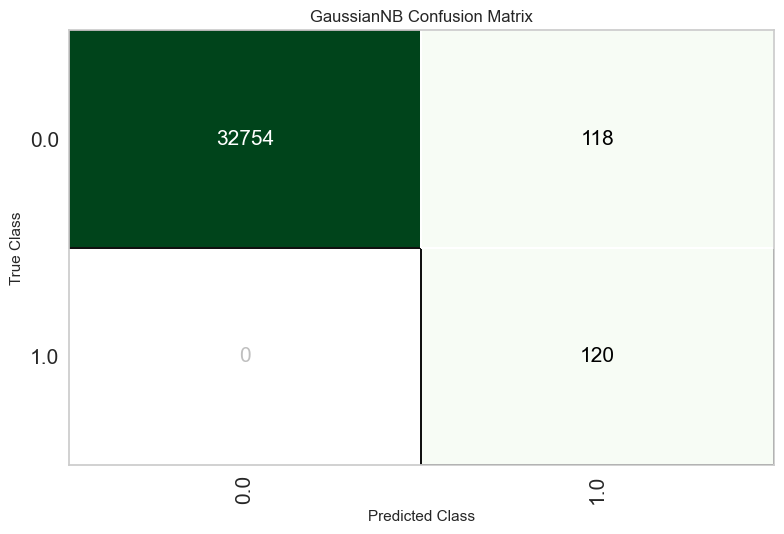

In [10]:
from pycaret.classification import setup, compare_models, plot_model

clf = setup(data=training_data, target="failure")

best = compare_models(sort="Recall")  # Sort models by recall
plot_model(best, plot="confusion_matrix")

In [ ]:
def forecast(measurements_table: str, cols_names: list[str]):
    # use bigquery's AI.FORECAST to predict all values of all columns in neuraltwin.wagon_data.measurements for each id for the next 7 days
    all_forecasts = []
    for col_name in cols_names:
        sql = f"""
            SELECT *
            FROM AI.FORECAST(
                TABLE `{measurements_table}`,
                data_col => '{col_name}',
                timestamp_col => 'timestamp',
                model => 'TimesFM 2.0',
                id_cols => ['id'],
                horizon => 7,
                confidence_level => .75
            )
        """
        forecast = pd.read_gbq(sql, project_id="neuraltwin", dialect="standard")
        forecast[col_name] = forecast["forecast_value"]
        forecast["timestamp"] = forecast["forecast_timestamp"]
        forecast = forecast[["id", "timestamp", col_name]]
        all_forecasts.append(forecast)
    # merge all forecasts on id and forecast_timestamp
    forecast = all_forecasts[0]
    for f in all_forecasts[1:]:
        forecast = forecast.merge(f, on=["id", "timestamp"])
    return forecast
forecast = forecast(
    measurements_table="neuraltwin.wagon_data.measurements",
    cols_names=measurements.columns.tolist().remove("id").remove("timestamp")
)

# Generate pdf report

In [16]:
recent_failures = pd.read_gbq(
    "SELECT * " \
    "FROM `neuraltwin.wagon_data.failures` " \
    f"WHERE timestamp >= TIMESTAMP_SUB(TIMESTAMP('{TODAY}'), INTERVAL 30 DAY)",
    project_id="neuraltwin",
    dialect="standard"
)

In [ ]:
- total number of wagons in operation
- number of recent failures
- percentage of wagons that have failed recently
- 

In [21]:
metadata

,Sensor_Installation_Date,Manufacture_Date,Operator,Height_m,Length_m,Owner,Width_m,Capacity_tons,Type,id
0,2021-09-22,2014-09-01,"Martin, Rogers and Mitchell",3.19,9.35,Butler-Williams,2.78,68,Boxcar,WGN-77257
1,2022-12-30,2017-04-03,Harris-Jenkins,4.47,20.19,Hanson-Williams,3.36,61,Boxcar,WGN-44982
2,2022-08-27,2006-03-18,"Patrick, Phillips and Sweeney",3.50,10.15,"Moran, Castillo and Gay",3.31,99,Boxcar,WGN-63070
3,2023-12-13,2013-09-30,Carson Ltd,4.08,16.69,Phillips Group,3.45,83,Boxcar,WGN-50340
4,2021-07-16,2008-01-11,Wilcox and Sons,4.02,22.08,Butler LLC,3.26,66,Boxcar,WGN-55682
...,...,...,...,...,...,...,...,...,...,...
95,2021-03-14,2013-09-16,Miller-Cole,3.23,12.91,"Ruiz, Flores and Cooley",3.25,55,Tank Car,WGN-25326
96,2021-08-12,2011-01-08,Fox-White,2.85,21.63,"Owens, Townsend and Price",3.12,84,Tank Car,WGN-51957
97,2024-06-12,2014-03-29,Osborne-King,2.01,21.27,Campbell Group,3.36,116,Tank Car,WGN-60041
98,2024-03-01,2000-10-18,Byrd-Williams,3.16,8.16,"Allen, Page and Larson",2.70,116,Tank Car,WGN-53799


In [30]:
metadata_object_columns = metadata.columns[metadata.dtypes == "object"].drop("id")

In [36]:
# find the object column in metadata with the least amount of unique values
{
    col: len(metadata[col].value_counts())
    for col in metadata_object_columns
}

{'Operator': 100, 'Owner': 100, 'Type': 6}

In [33]:
metadata[metadata_object_columns].value_counts()

Operator          Owner                      Type            
Berg-Houston      Nicholson PLC              Hopper              1
Oneal-Graham      Murphy-Patrick             Hopper              1
Reed-Hart         Torres-Scott               Refrigerator Car    1
Ray-Bradford      Hill, Adams and Savage     Gondola             1
Pope-Green        Shaw LLC                   Gondola             1
                                                                ..
Harris-Jenkins    Hanson-Williams            Boxcar              1
Harris LLC        Curry, Wyatt and Mitchell  Boxcar              1
Hardin-Anderson   Rowe-Holden                Gondola             1
Guzman and Sons   Lopez, Lee and Thompson    Hopper              1
Zuniga-Hernandez  Petersen Group             Tank Car            1
Name: count, Length: 100, dtype: int64

In [18]:
metadata = pd.read_gbq(
    "SELECT * FROM `neuraltwin.wagon_data.metadata`",
    project_id="neuraltwin",
    dialect="standard"
)
# merge recent_failures with metadata on id
recent_failures_enriched = recent_failures.merge(metadata, on="id", how="left")

In [19]:
recent_failures_enriched

,timestamp,repair_time,downtime,cause,id,Sensor_Installation_Date,Manufacture_Date,Operator,Height_m,Length_m,Owner,Width_m,Capacity_tons,Type
0,2025-07-25 00:00:00+00:00,2025-07-26 00:00:00+00:00,1 days 00:00:00,axle failure,WGN-97252,2021-08-29,2006-06-22,"Jones, Reese and Collier",2.78,23.90,"Davis, Short and Neal",3.40,38,Refrigerator Car
1,2025-07-24 00:00:00+00:00,2025-07-24 17:00:00+00:00,0 days 17:00:00,battery failure,WGN-37611,2021-05-12,1998-10-02,Wilson-Johnson,4.06,18.39,"Wilson, Zavala and Taylor",3.10,120,Gondola
2,2025-07-28 00:00:00+00:00,2025-07-28 21:00:00+00:00,0 days 21:00:00,battery failure,WGN-26650,2023-09-24,2019-10-09,Payne-Davis,2.59,17.84,"Johnson, Stevens and Young",2.96,80,Flatcar
3,2025-07-04 00:00:00+00:00,2025-07-04 05:00:00+00:00,0 days 05:00:00,brakes failure,WGN-17692,2020-12-07,2004-06-28,"Garcia, Huff and Adams",3.84,11.62,Sandoval and Sons,3.29,47,Flatcar
4,2025-07-12 00:00:00+00:00,2025-07-12 10:00:00+00:00,0 days 10:00:00,brakes failure,WGN-44982,2022-12-30,2017-04-03,Harris-Jenkins,4.47,20.19,Hanson-Williams,3.36,61,Boxcar
5,2025-07-03 00:00:00+00:00,2025-07-03 12:00:00+00:00,0 days 12:00:00,brakes failure,WGN-22379,2022-12-25,2014-11-02,Fletcher Group,2.97,14.33,Leach-Thompson,3.29,32,Hopper
6,2025-07-20 00:00:00+00:00,2025-07-20 12:00:00+00:00,0 days 12:00:00,cooling failure,WGN-39103,2024-05-18,2003-06-09,Oneal-Graham,4.39,18.24,Murphy-Patrick,3.28,29,Hopper
7,2025-07-10 00:00:00+00:00,2025-07-10 17:00:00+00:00,0 days 17:00:00,cooling failure,WGN-53799,2024-03-01,2000-10-18,Byrd-Williams,3.16,8.16,"Allen, Page and Larson",2.70,116,Tank Car
8,2025-07-26 00:00:00+00:00,2025-07-26 22:00:00+00:00,0 days 22:00:00,cooling failure,WGN-22477,2022-07-09,2006-11-02,Thomas Group,3.88,14.01,"Wiley, Chavez and Gomez",2.98,46,Tank Car


In [ ]:
recent_measurements = pd.read_gbq(
    "SELECT *" \
    "FROM `neuraltwin.wagon_data.measurements`" \
    "WHERE timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)",
    project_id="neuraltwin",
    dialect="standard"
)
recent_failures = pd.read_gbq(
    "SELECT *" \
    "FROM `neuraltwin.wagon_data.failures`" \
    "WHERE timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)",
    project_id="neuraltwin",
    dialect="standard"
)
metadata = pd.read_gbq(
    "SELECT *" \
    "FROM `neuraltwin.wagon_data.metadata`",
    project_id="neuraltwin",
    dialect="standard"
)

In [1]:
# generate pdf report
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.cell(200, 10, txt="Hello World", ln=True, align='C')
pdf.output("report.pdf")

C:\Users\Fabian Klos\AppData\Local\Temp\ipykernel_17948\1534846195.py:5: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=12)
C:\Users\Fabian Klos\AppData\Local\Temp\ipykernel_17948\1534846195.py:6: DeprecationWarning: The parameter "txt" has been renamed to "text" in 2.7.6
  pdf.cell(200, 10, txt="Hello World", ln=True, align='C')
C:\Users\Fabian Klos\AppData\Local\Temp\ipykernel_17948\1534846195.py:6: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(200, 10, txt="Hello World", ln=True, align='C')


In [45]:
# read in metadata and print the first 5 rows
metadata = pd.read_json("../../data/wagon_data/metadata/combined_metadata.ndjson", lines=True)

In [46]:
operators = metadata["Operator"].to_list()[:10]

In [48]:
import random


metadata["Operator"] = [operators[random.randint(0,len(operators)-1)] for _ in range(len(metadata))]
metadata

,id,Type,Capacity_tons,Length_m,Width_m,Height_m,Operator,Owner,Manufacture_Date,Sensor_Installation_Date
0,WGN-22477,Tank Car,46,14.01,2.98,3.88,Wilson-Johnson,"Wiley, Chavez and Gomez",2006-11-02,2022-07-09
1,WGN-82978,Hopper,24,22.54,3.16,2.02,Thomas Group,Guerra and Sons,1996-03-03,2023-12-30
2,WGN-39262,Tank Car,59,9.90,2.79,2.63,Torres-Ortiz,Hernandez-Barrett,2001-09-25,2023-01-05
3,WGN-37611,Gondola,120,18.39,3.10,4.06,Torres-Ortiz,"Wilson, Zavala and Taylor",1998-10-02,2021-05-12
4,WGN-77257,Boxcar,68,9.35,2.78,3.19,Rodriguez and Sons,Butler-Williams,2014-09-01,2021-09-22
...,...,...,...,...,...,...,...,...,...,...
95,WGN-79653,Hopper,99,20.96,2.50,4.34,Harris-Jenkins,Bartlett-Kelly,2020-05-21,2021-05-19
96,WGN-40272,Gondola,38,18.39,2.53,4.46,Charles and Sons,"Terry, Thompson and Johnson",2012-04-06,2023-06-14
97,WGN-60041,Tank Car,116,21.27,3.36,2.01,Hendricks and Sons,Campbell Group,2014-03-29,2024-06-12
98,WGN-53799,Tank Car,116,8.16,2.70,3.16,Brennan-Peterson,"Allen, Page and Larson",2000-10-18,2024-03-01


In [49]:
metadata.to_json("../../data/wagon_data/metadata/combined_metadata.ndjson", lines=True, orient="records")

,id,Type,Capacity_tons,Length_m,Width_m,Height_m,Operator,Owner,Manufacture_Date,Sensor_Installation_Date
0,WGN-22477,Tank Car,46,14.01,2.98,3.88,Wilson-Johnson,"Wiley, Chavez and Gomez",2006-11-02,2022-07-09
1,WGN-82978,Hopper,24,22.54,3.16,2.02,Thomas Group,Guerra and Sons,1996-03-03,2023-12-30


In [58]:
metadata[:2].to_gbq(
    "neuraltwin.wagon_data.test_metadata",
    project_id="neuraltwin",
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<00:00, 976.56it/s]


In [ ]:
query = """SELECT
  id,
  Type,
  AI.GENERATE(
    (
      'Generate a description for a wagon of type ' || Type || ' with a capacity of: ' || CAST(Capacity_tons AS STRING)
    ),
    connection_id => 'projects/neuraltwin/locations/us-central1/connections/neuraltwin-us-vertex-connection',
    endpoint => 'gemini-2.0-flash-lite'
  ).result AS report
FROM
  `neuraltwin.wagon_data.test_metadata`;
"""
reports = bigquery_client.query(query).result()

BadRequest: 400 POST https://bigquery.googleapis.com/bigquery/v2/projects/neuraltwin/jobs?prettyPrint=false: Location eu-central1 does not support this operation.

Location: None
Job ID: 4a81f342-99ea-4ef6-b83d-c4977971c38e
